# Modeling Heights and Weights

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, colors
import numpy as np

In [2]:
# Some settings for making pretty plots

prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [colors.to_rgb(c) for c in prop_cycle.by_key()['color']]
r0, g0, b0 = cs[0]
r1, g1, b1 = cs[1]
r2, g2, b2 = cs[2]

In [3]:
df = pd.read_csv("./height-weight.csv")
df

,Height,Weight,Gender
0,73.847017,241.893563,Male
1,68.781904,162.310473,Male
2,74.110105,212.740856,Male
3,71.730978,220.042470,Male
4,69.881796,206.349801,Male
...,...,...,...
9995,66.172652,136.777454,Female
9996,67.067155,170.867906,Female
9997,63.867992,128.475319,Female
9998,69.034243,163.852461,Female


In [126]:
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the rows.
X = df[["Height", "Weight"]].values
y = 1*(df.Gender == "Female").values

MALE = 0
FEMALE = 1

# boolean array indexing: https://numpy.org/devdocs/reference/arrays.indexing.html#boolean-array-indexing
X_m = X[y == MALE]
X_f = X[y == FEMALE]

y = 1*(y == FEMALE)

n_m = len(X_m)
n_f = len(X_f)

print(f"Data set contains heights of {n_m} men and {n_f} women.") # format string

Data set contains heights of 5000 men and 5000 women.


### Density Estimation

Estimate the densities for:

1. the heights and weights of women,
2. the heights and weights of men, and
3. the heighs and weights of both women and men.

Do this
1. nonparametrically, using histograms, and
2. parametrically, by assuming the distribution of the heights of women and the distribution of the heights of men are both Gaussian.

In [39]:
mean_m = np.mean(X_m, axis=0)
cov_m = np.cov(X_m.T)

mean_f = np.mean(X_f, axis=0)
cov_f = np.cov(X_f.T)

mean_all = np.mean(X)
cov_all = np.cov(X)

p_m = n_m/(n_m + n_f)
p_f = n_f/(n_m + n_f)

In [49]:
from scipy.stats import multivariate_normal as mvn

hmin, wmin = np.min(X, axis=0)
hmax, wmax = np.max(X, axis=0)
hs = np.linspace(hmin, hmax, 100)
ws = np.linspace(wmin, wmax, 100)
H, W = np.meshgrid(hs, ws)
np.stack((H, W), axis=-1)
pdf_m = mvn.pdf(HW, mean=mean_m, cov=cov_m);
pdf_f = mvn.pdf(HW, mean=mean_f, cov=cov_f);
pdf = p_m*pdf_m + p_f*pdf_f

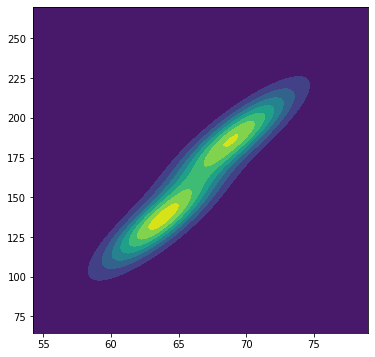

In [48]:
plt.figure(figsize=(6, 6))
plt.contourf(H, W, pdf);

In [6]:
# Gaussian density

def g(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

## Unsupervised Learning

### $K$-Means Clustering

Cluster the data using the $K$-means algorithm. Do the clusters reflect genders?

Cluster accuracy:  0.9026 0.0898


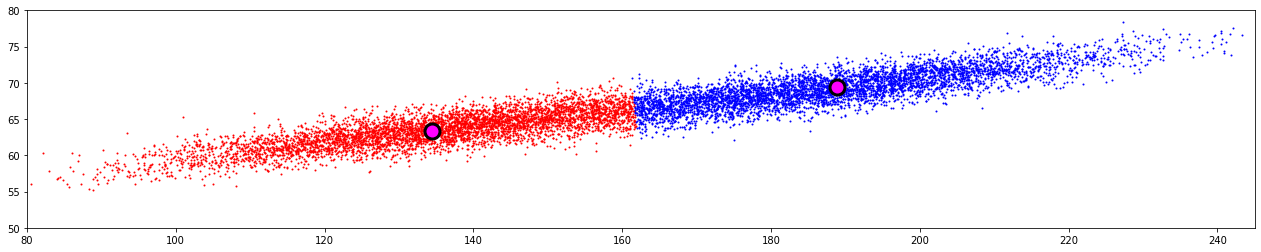

In [132]:
from sklearn.cluster import KMeans

M = KMeans(n_clusters=2)
labels = M.fit_predict(X)

r = (245 - 80)/(80-50)
plt.figure(figsize=(4*r, 4))
plt.ylim(50, 80)
plt.xlim(80, 245)
plt.plot(X[labels == 0, 1], X[labels == 0, 0], 'ro', markersize=1)
plt.plot(X[labels == 1, 1], X[labels == 1, 0], 'bo', markersize=1)
plt.plot(M.cluster_centers_[:,1], M.cluster_centers_[:,0], 'o', color="fuchsia", markersize=15, mec='k', mew=3)
# plt.contour(W, H, pdf_m.T, linewidths=3, colors=colors.to_hex((r2, g2, b2)));
# plt.contour(W, H, pdf_f.T, linewidths=3, colors=colors.to_hex((r1, g1, b1)));

print("Cluster accuracy: ", labels[y == 0].sum()/5000, labels[y == 1].sum()/5000)

### Gaussian Mixture Model

Without using gender information, model height and weight as a mixture of two 2d Gaussians.
Use your model to *predict* gender based on height and weight.

Cluster accuracy:  0.085 0.9188


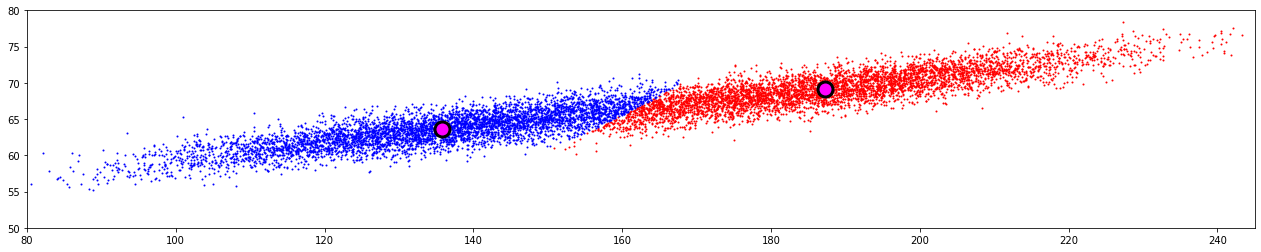

In [133]:
from sklearn.mixture import GaussianMixture

M = GaussianMixture(n_components=2)
labels = M.fit_predict(X)

r = (245 - 80)/(80-50)
plt.figure(figsize=(4*r, 4))
plt.ylim(50, 80)
plt.xlim(80, 245)
plt.plot(X[labels == 0, 1], X[labels == 0, 0], 'ro', markersize=1)
plt.plot(X[labels == 1, 1], X[labels == 1, 0], 'bo', markersize=1)
plt.plot(M.means_[:,1], M.means_[:,0], 'o', color="fuchsia", markersize=15, mec='k', mew=3)

print("Cluster accuracy: ", labels[y == 0].sum()/5000, labels[y == 1].sum()/5000)

## Supervised Learning

### Train/Test Split

In [134]:
X_train = X[:9000, :]
y_train = y[:9000]
X_test = X[9000:, :]
y_test = y[9000:]

### Logistic Regression

$$
p(y=1|x) = \frac{1}{1 + \exp\big(-(\beta_0 + \beta_1x_1 + \beta_2x_2)\big)}
$$

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
M = LogisticRegression(solver="lbfgs")
M.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
y_predict = M.predict(X_test)
print(f"Accuracy on test set: {np.sum(y_predict == y_test)/len(y_test)}")

Accuracy on test set: 0.93


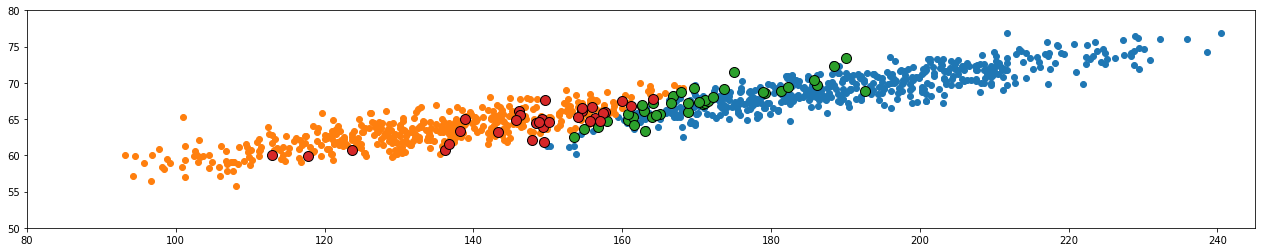

In [151]:
I00 = np.logical_and(y_predict == 0, y_test == 0) # confusion matrix
I01 = np.logical_and(y_predict == 0, y_test == 1)
I10 = np.logical_and(y_predict == 1, y_test == 0)
I11 = np.logical_and(y_predict == 1, y_test == 1)

r = (245 - 80)/(80-50)
plt.figure(figsize=(4*r, 4))
plt.ylim(50, 80)
plt.xlim(80, 245)

plt.plot(X_test[I00, 1], X_test[I00, 0], 'o')
plt.plot(X_test[I11, 1], X_test[I11, 0], 'o')
plt.plot(X_test[I01, 1], X_test[I01, 0], 'o', mec='k', markersize=10)
plt.plot(X_test[I10, 1], X_test[I10, 0], 'o', mec='k', markersize=10)

### The Bayes Classifier

$$
\begin{aligned}
x&\in\mathbb{R}&&\text{height}\\
\\
z&\in\{\text{male, female}\}&&\text{class label}\\
\\
p(z=i|x) &= \frac{p(x|z=i)p(z=i)}{p(x)}&&\text{Bayes' Theorem}\\
&= \frac{p(x|z=i)p(z=i)}{p(x|z=0)p(z=0) + p(x|z=1)p(z=1)}&&\text{by the Law of Total Probability}
\end{aligned}
$$

11 11


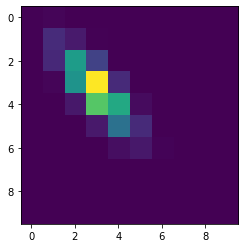

In [212]:
X_f = X_train[y_train == FEMALE, :]
X_m = X_train[y_train == MALE, :]

density, bins = np.histogramdd(X, density=True, bins=10)
(h_bins, w_bins) = bins
# bins = np.arange(np.floor(np.min(X_train)), np.ceil(np.max(X_train)))

hist_f, bins_f = np.histogramdd(X_f, bins=bins, density=True)
hist_m, bins_m = np.histogramdd(X_m, bins=bins, density=True)
plt.imshow(hist_f)
print(len(h_bins), len(w_bins))

In [216]:
h_bins = np.array(h_bins).reshape(1, -1)
w_bins = np.array(w_bins).reshape(1, -1)

print(h_bins.shape, w_bins.shape)

p_f = len(X_female)/(len(X_female) + len(X_male))
p_m = len(X_male)/(len(X_female) + len(X_male))

i = np.argmin(X_test[:,0].reshape(-1, 1) > h_bins, axis=1) - 1
j = np.argmin(X_test[:,1].reshape(-1, 1) > w_bins, axis=1) - 1
p_x_f = hist_f[i, j]
p_x_m = hist_m[i, j]
# p_x_male = hist_m[np.argmin(X_test[:,0].reshape(-1, 1) > h_bins, axis=1) - 1, np.argmin(X_test[:,1].reshape(-1, 1) > w_bins, axis=1) - 1]

p_x = p_x_f*p_f + p_x_m*p_m
p_f_x = p_x_f*p_f/p_x
p_m_x = p_x_m*p_m/p_x

(1, 11) (1, 11)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [217]:
p_x.shape

(1000,)

In [218]:
y_pred = 1.0*(p_m_x < p_f_x)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [221]:
np.sum(y_pred == y_test)/len(y_test)

0.902